# Libraries

In [1]:
#!pip install imbalanced-learn

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

import seaborn as sns
from pylab import rcParams
#from matplotlib import pyplot as plt
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

# Load Dataset

In [2]:
# df = pd.read_csv("Kaggle-credit-card-fraud-detection_18Sep23/creditcard_2023.csv")
df = pd.read_csv("Kaggle-credit-card-fraud-detection-US_13Jul24/creditcard.csv")


In [3]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# Exploration

In [4]:
df.shape

(284807, 31)

In [5]:
df.isnull().values.any()

False

C:\Users\flyin\AppData\Local\Temp\ipykernel_46120\2107955042.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(df['Class'], sort = True)


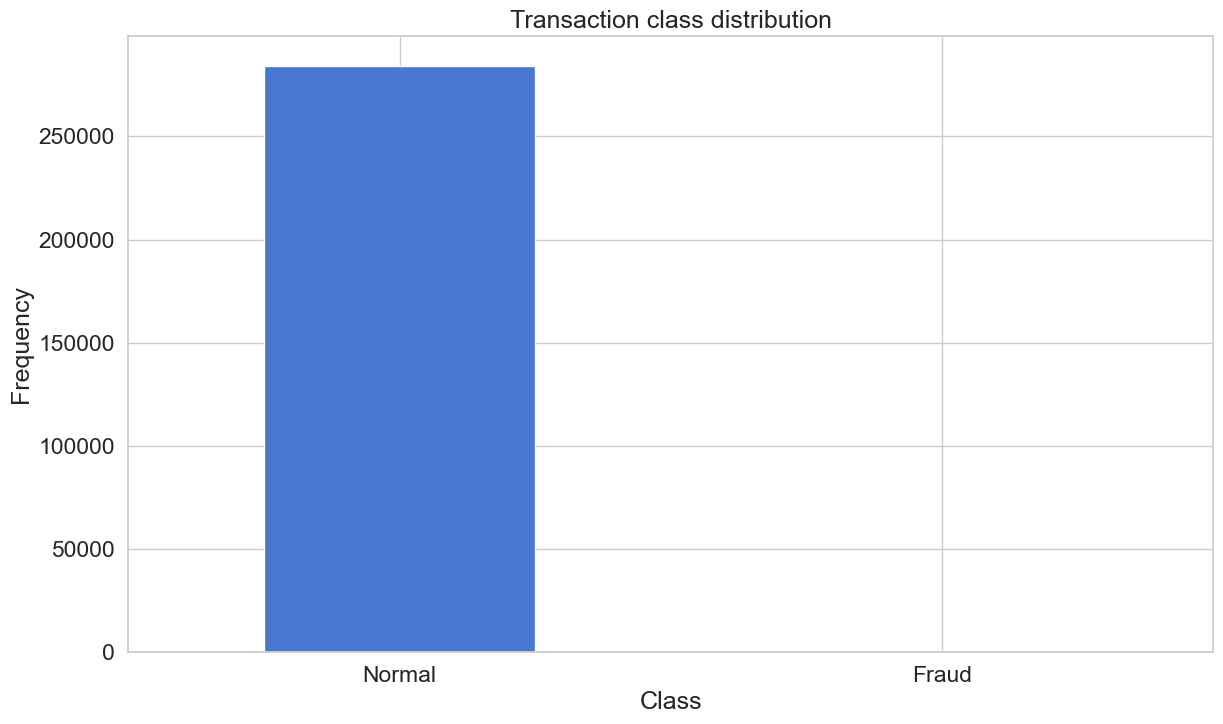

In [6]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

We have a highly imbalanced dataset on our hands. Normal transactions overwhelm the fraudulent ones by a large margin. Let's look at the two types of transactions:

In [7]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

In [8]:
frauds.shape

(492, 31)

In [9]:
normal.shape

(284315, 31)

# 1. Data Preprocessing

### Separate features and labels

In [10]:
X = df.drop(['Class'], axis=1)  # 'Class' is the fraud label
y = df['Class']

### Split the data into training and testing sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Standardize the features

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Unsupervised Learning with Autoencoder for Anomaly Detection

In [14]:
def build_autoencoder(input_dim):
    input_layer = layers.Input(shape=(input_dim,))
    encoder = layers.Dense(16, activation="relu")(input_layer)
    encoder = layers.Dense(8, activation="relu")(encoder)
    decoder = layers.Dense(16, activation='relu')(encoder)
    decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)
    autoencoder = models.Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

In [15]:
input_dim = X_train_balanced_scaled.shape[1]
autoencoder = build_autoencoder(input_dim)
autoencoder.fit(X_train_balanced_scaled, X_train_balanced_scaled, epochs=20, batch_size=256, 
                validation_data=(X_test_scaled, X_test_scaled), verbose=1)


Epoch 1/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 11.1893 - val_loss: 0.8644
Epoch 2/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step - loss: 10.8120 - val_loss: 0.8341
Epoch 3/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.8164 - val_loss: 0.8254
Epoch 4/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - loss: 10.7834 - val_loss: 0.8217
Epoch 5/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.7825 - val_loss: 0.8188
Epoch 6/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 10.7972 - val_loss: 0.8155
Epoch 7/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 10.7337 - val_loss: 0.8115
Epoch 8/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 10.7536 - val_loss: 0.8075
Epoch 9/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.7458 - val_loss: 0.8051
Epoch 10/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.8441 - val_loss: 0.8036
Epoch 11/20
1555/1555 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 10.7564 - val_loss: 0.8020
Epoch 12/20
155

### Generate reconstruction errors

In [16]:
train_reconstructions = autoencoder.predict(X_train_scaled)
train_mse = np.mean(np.power(X_train_scaled - train_reconstructions, 2), axis=1)


6231/6231 ━━━━━━━━━━━━━━━━━━━━ 3s 513us/step


In [17]:
test_reconstructions = autoencoder.predict(X_test_scaled)
test_mse = np.mean(np.power(X_test_scaled - test_reconstructions, 2), axis=1)


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 1s 554us/step


### Add the reconstruction error as a feature to the Dca dataset

In [18]:
X_train['reconstruction_error'] = train_mse
X_test['reconstruction_error'] = test_mse


# 3. Unsupervised Learning with KMeans Clustering

In [19]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=2, random_state=42)

### Add the cluster labels as features

In [20]:
X_train['cluster_label'] = kmeans.labels_
X_test['cluster_label'] = kmeans.predict(X_test_scaled)

# 4. Handling Imbalanced Data with SMOTE (Optional)


In [30]:
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)


# 5. Supervised Learning using Random Forest

In [31]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_balanced, y_train_balanced)



KeyboardInterrupt



### Make predictions

In [23]:
y_pred = rf_clf.predict(X_test)

# 6. Model Evaluation

In [24]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.88      0.78      0.83       148

    accuracy                           1.00     85443
   macro avg       0.94      0.89      0.91     85443
weighted avg       1.00      1.00      1.00     85443



### ROC AUC Score

In [25]:
roc_score = roc_auc_score(y_test, y_pred)
print(f"ROC AUC Score: {roc_score}")


ROC AUC Score: 0.8884255833886526


### Confusion Matrix

In [26]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Confusion Matrix:
[[85280    15]
 [   33   115]]


# 7. Plotting ROC Curve (Optional)

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve


In [28]:
y_probas = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probas)


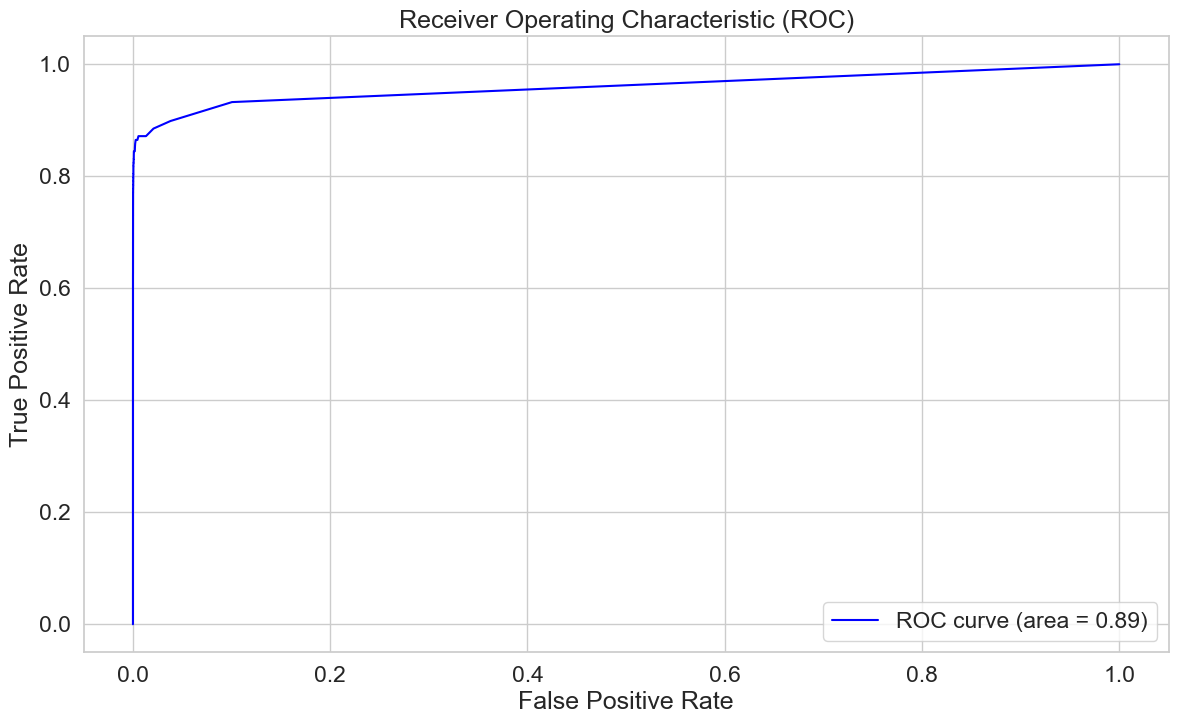

In [29]:
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_score:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()